# LSTM과 CNN의 조합을 이용한 IMDB 영화 리뷰 감성 분류

- 모든 단어가 아닌 빈도수 5000 까지
- 모든 문장이 아니라 100 단어까지
- Embedding 벡터는 120 차원

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.datasets import imdb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, LSTM, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# 등장 빈도가 5,000번째까지의 단어들만 사용
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

In [4]:
# 모델의 입력으로 사용하는 모든 리뷰의 길이를 동일하게 100으로 맞춤
max_len=500
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [5]:
# LSTM, CNN 모델
model = Sequential()
model.add(Embedding(5000, 120))
model.add(Dropout(0.5)) 
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         600000    
_________________________________________________________________
dropout (Dropout)            (None, None, 120)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 55)                26400     
_________________________________________________________________
dense (Dense)                (None, 1)                 56        
Total params: 664,920
Trainable params: 664,920
Non-trainable params: 0
__________________________________________________

In [6]:
# 모델의 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('model/imdb_cnn_best_model.h5', monitor='val_accuracy', 
                     verbose=1, mode='max', save_best_only=True)

In [8]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5,
                    batch_size=64, callbacks=[mc, es])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
24960/25000 [============================>.] - ETA: 0s - loss: 0.3872 - accuracy: 0.8128
Epoch 00001: val_accuracy improved from -inf to 0.88360, saving model to model/imdb_cnn_best_model.h5
25000/25000 [==============================] - 58s 2ms/sample - loss: 0.3868 - accuracy: 0.8130 - val_loss: 0.2789 - val_accuracy: 0.8836
Epoch 2/5
24960/25000 [============================>.] - ETA: 0s - loss: 0.2341 - accuracy: 0.9060
Epoch 00002: val_accuracy improved from 0.88360 to 0.89080, saving model to model/imdb_cnn_best_model.h5
25000/25000 [==============================] - 56s 2ms/sample - loss: 0.2340 - accuracy: 0.9061 - val_loss: 0.2644 - val_accuracy: 0.8908
Epoch 3/5
24960/25000 [============================>.] - ETA: 0s - loss: 0.1858 - accuracy: 0.9310
Epoch 00003: val_accuracy did not improve from 0.89080
25000/25000 [==============================] - 56s 2ms/sample - loss: 0.1858 - accuracy: 0.9311 - val_loss: 0.2692 

In [9]:
# Best Model 선택
from tensorflow.keras.models import load_model
del model
model = load_model('model/imdb_cnn_best_model.h5')

In [10]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(x_test, y_test, verbose=2)[1]))

25000/25000 - 12s - loss: 0.2644 - accuracy: 0.8908

 테스트 정확도: 0.8908


In [11]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

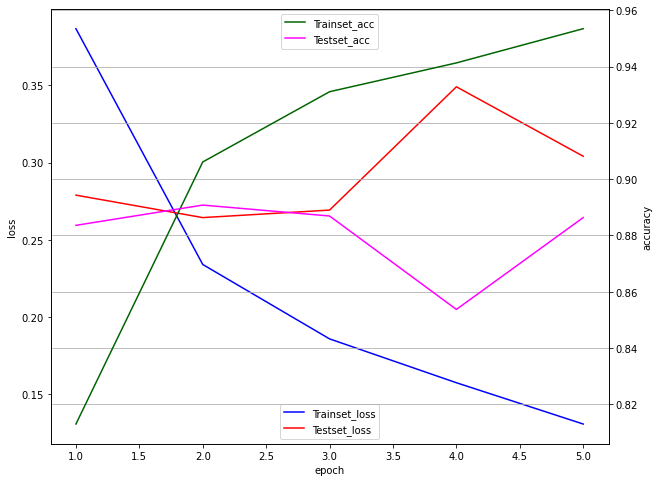

In [12]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()